In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

Assumptions: Here, the train dataset has been consider as the entire population data, hence we have divided the data into in-sample(80%) and out-of-sample (20%) data. 


In [2]:
cd Downloads

/Users/sagarsahoo/Downloads


In [3]:
train_df = pd.read_csv("train.csv")

In [4]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let us check the shape of the Dataset: 

In [15]:
train_df.shape

(891, 12)

We check for distribution of Positive and Negative Class: 

In [13]:
print("Not Survived Class : ", 100 * train_df.Survived.value_counts()[0] / len(train_df))
print("Survived Class : ", 100 * train_df.Survived.value_counts()[1] / len(train_df))

Not Survived Class :  61.61616161616162
Survived Class :  38.38383838383838


Now, we check for missing values:

In [5]:
missing_df = train_df.isnull().sum().reset_index()
missing_df[missing_df[0] > 0]

,index,0
5,Age,177
10,Cabin,687
11,Embarked,2


So we have missing values only in Age, Cabin and Embarked Column. Here I have assumed Cabin as irrelevant to our analysis, so I am dropping the column from our dataframe.

And there are 2 rows wherein Embarked Column is missing, and hence we can drop these rows from our analysis.

In [26]:
train_df.drop(['Cabin'], axis = 1, inplace = True)
train_df.dropna(subset=['Embarked'],inplace=True)

Outliers: We have used IQR to identify the outliers in Features: "Age","SibSp","Parch","Fare"

In [22]:
# Outlier detection 

def detect_outliers(df,n,features):
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_df,2,["Age","SibSp","Parch","Fare"])

Lets have a look at the outliers in the data and drop them from the dataset:

In [23]:
train_df.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.00,C23 C25 C27,S
587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.20,B41,C
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,9.0,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,16.0,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,16.0,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,16.0,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S


We can remove the outliers from our analysis.

In [24]:
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [18]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We impute the missing Age with KNN Algorithm using PClass, SibSp, Parch and Age as the features for KNN. 
Mean and Median are not accurate to impute here for Age

In [21]:
%%capture
from fancyimpute import KNN
#warnings.filterwarnings('ignore')
# you have to uninstall numpy and reinstall numpy
# you have to install tensorflow for fancyimpute to work

missing = KNN(k=1).fit_transform(train_df[['Pclass','SibSp','Parch','Age']])
train_df['Age'] = missing[:,-1]

Just to confirm, now we dont have any missing values in the dataframe:

In [27]:
missing_df = train_df.isnull().sum().reset_index()
missing_df[missing_df[0] > 0]

,index,0


# Feature Engineering

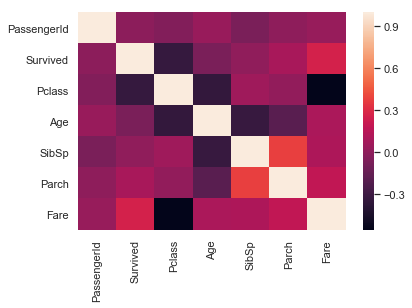

In [30]:
sns.heatmap(train_df.corr())
#train_df.corr().unstack().sort_values().drop_duplicates()

In [20]:
    train_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


This correlation matrix is not to understand the correlation of response with features (as the response is a binary categorical response and features are continuous), rather it is visualize the correlation among the features.


We could see that SibSp and Parch are highly correlated we introduce a new variable "family_size" and then drop both columns.

In [28]:
train_df["family_size"] = train_df["SibSp"] + train_df["Parch"] + 1

In [29]:
X = train_df[[ 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'family_size']]
y = train_df['Survived']

We now introduce dummy variables for the categorical features:  Embarked, PClass and Sex!

In [30]:
X = pd.get_dummies(data=X, columns=['Embarked','Pclass','Sex'])

In [31]:
X.head(5)

,Age,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,22.0,7.2500,2,0,0,1,0,0,1,0,1
1,38.0,71.2833,2,1,0,0,1,0,0,1,0
2,26.0,7.9250,1,0,0,1,0,0,1,1,0
3,35.0,53.1000,2,0,0,1,1,0,0,1,0
4,35.0,8.0500,1,0,0,1,0,0,1,0,1


In [32]:
y.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

We scale the feature Age, Fare, family_size using Standard Scaler. Some algorithms use Eucleadian Distance, and hence the reason for scaling features.

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X['Age']=scaler.fit_transform(X.Age.values.reshape(-1, 1))
X['Fare']=scaler.fit_transform(X.Fare.values.reshape(-1, 1))
X['family_size']=scaler.fit_transform(X.family_size.values.reshape(-1, 1))

Now, we split the dataset into training and test datasets.

In [34]:
#X.drop(['Survived'], axis = 1, inplace = True)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [35]:
X_train.head(5)

,Age,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
399,1.630678,-0.483457,-0.590563,0,0,1,0,0,1,0,1
546,-0.537434,-0.482929,-0.590563,0,0,1,0,0,1,1,0
523,0.210191,-0.494454,-0.590563,1,0,0,0,0,1,0,1
769,1.032578,3.815577,0.136028,0,0,1,1,0,0,1,0
236,-0.537434,-0.319805,0.136028,0,1,0,0,0,1,1,0


# Logistic Regression

In [58]:
logisticReg = LogisticRegression()
logisticReg.fit(X_train, y_train)
#logisticReg.coef_
y_pred = logisticReg.predict(X_test)
y_pred_proba = logisticReg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

In [59]:
print(logisticReg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logisticReg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logisticReg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

LogisticRegression accuracy is 0.761
LogisticRegression log_loss is 0.497
LogisticRegression auc is 0.817


For classification problems, ideally AUC is a good measure. Here we got a score of 0.817 without regularization. Now we use GridSearchCV to run Logistic Regression at various values of C:

In [60]:
from sklearn.model_selection import GridSearchCV


param_grid = {'C': np.arange(1e-05, 3, 0.1)}

scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_train, y_train)
results = gs.cv_results_

print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)


y_pred_proba = logisticReg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

print(accuracy_score(y_test, y_pred))
print(auc(fpr, tpr))

best params: LogisticRegression(C=0.20001000000000002, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
best params: {'C': 0.20001000000000002}
best score: 0.8095171026156942
0.7613636363636364
0.8166666666666667


GridSearchCV with 10 Fold Cross Validation gave us a AUC of 0.8166 for C = 0.2

# Support Vector Machines

We now try, Polynomial SVM :

In [61]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8,probability=True)
svclassifier.fit(X_train, y_train)
y_svc_pred = svclassifier.predict(X_test)
y_svc_pred_proba = svclassifier.predict_proba(X_test)[:, 1]
[fpr_svc, tpr_svc, thr_svc] = roc_curve(y_test, y_svc_pred_proba)
print(svclassifier.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_svc_pred))
print(svclassifier.__class__.__name__+" auc is %2.3f" % auc(fpr_svc, tpr_svc))

SVC accuracy is 0.756
SVC auc is 0.813


And now Gaussian Kernel: 

In [62]:
rbf_svclassifier = SVC(kernel='rbf',probability=True)
rbf_svclassifier.fit(X_train, y_train)
y_rbf_pred = rbf_svclassifier.predict(X_test)
y_rbf_pred_proba = rbf_svclassifier.predict_proba(X_test)[:, 1]
[fpr_svc, tpr_svc, thr_svc] = roc_curve(y_test, y_rbf_pred_proba)
print(svclassifier.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_rbf_pred))
print(svclassifier.__class__.__name__+" auc is %2.3f" % auc(fpr_svc, tpr_svc))

SVC accuracy is 0.790
SVC auc is 0.836


Gaussian Kernel gave better performance as compared to Polynomial Kernel. We now use GridSearchCV to get the best hyperparameters.

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','poly','sigmoid']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.816, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.738, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.752, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.750, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.757, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.794, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.787, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.800, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.829, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.681, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.688, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.681, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.693, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[CV] ............ C=1, gamma=1, kernel=rbf, score=0.786, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.843, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.787, total=   0.4s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.752, total=   0.2s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.787, total=   0.5s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.771, total=   1.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........... C=1, gamma=1, kernel=poly, score=0.807, total=   0.5s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] .

[CV] ... C=1, gamma=0.0001, kernel=sigmoid, score=0.614, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=sigmoid ...............................
[CV] ... C=1, gamma=0.0001, kernel=sigmoid, score=0.614, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.801, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.773, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.787, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.764, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.793, total=   0.0s
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] .

[CV] ..... C=10, gamma=0.0001, kernel=poly, score=0.614, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.617, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.610, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.610, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.614, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.621, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.773, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.610, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.614, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.614, total=   0.0s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] .. C=100, gamma=0.001, kernel=sigmoid, score=0.816, total=   0.0s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] .. C=100, gamma=0.001, kernel=sigmoid, score=0.730, total=   0.0s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] .. C=100, gamma=0.001, kernel=sigmoid, score=0.759, total=   0.0s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] .. C=100, gamma=0.001, kernel=sigmoid, score=0.829, total=   0.0s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] .

# Decision Trees

In [36]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [37]:
print('Training Score: ',clf.score(X_train, y_train))
print('Test Score: ',clf.score(X_test, y_test))

Training Score:  0.9771428571428571
Test Score:  0.7670454545454546


In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
clf_pred_proba = clf.predict_proba(X_test)
print ('Decision Tree AUC: ',roc_auc_score(y_test, clf_pred_proba[:,1]))

Decision Tree AUC:  0.7547409188034189


So, we got an AUC Score of 0.75 with default hyperparameters. Now, we go for GridSearchCV.

In [39]:
from sklearn.model_selection import GridSearchCV
dtc = DecisionTreeClassifier(random_state=0)

# Define the parameter values that should be searched

param_grid = {'criterion':('gini', 'entropy'), 'max_depth':[4,6,8,12],
              'min_samples_split':list(range(2, 100))}

# instantiate the grid
grid = GridSearchCV(dtc, param_grid, cv=10, scoring='accuracy')

# fit the grid with data
grid.fit(X_train, y_train)

# examine the best model

# Single best score achieved across all params (min_samples_split)
print(grid.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid.best_estimator_)

0.8385714285714286
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


In [152]:
print('Test Score: ',grid.score(X_test, y_test))

Test Score:  0.7752808988764045


In [40]:
clf_gv_pred_proba = grid.predict_proba(X_test)
print ('GridSearch Decision Tree AUC: ',roc_auc_score(y_test, clf_gv_pred_proba[:,1]))

GridSearch Decision Tree AUC:  0.8362045940170941


# Random Forest 

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc_best = RandomForestClassifier(n_jobs= 1, max_depth=3,random_state=2018 , criterion='entropy', 
                             n_estimators= 20, verbose=False)
rfc_best.fit(X_train,y_train)
rfc_best.score(X_test,y_test)

0.7840909090909091

In [42]:
y_rfc_pred = rfc_best.predict(X_test)
accuracy_score(y_test, y_rfc_pred)

0.7840909090909091

In [43]:
from sklearn.model_selection import GridSearchCV
dtc = RandomForestClassifier(random_state=2018)

# Define the parameter values that should be searched

param_grid = {'criterion':('gini', 'entropy'), 'max_depth':[4,6,8,12],'n_estimators':[10,20,30,40],
              'min_samples_split':list(range(2, 100))}

# instantiate the grid
rf_grid = GridSearchCV(dtc, param_grid, cv=10, scoring='accuracy')

# fit the grid with data
rf_grid.fit(X_train, y_train)

# examine the best model

# Single best score achieved across all params (min_samples_split)
print(rf_grid.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(rf_grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(rf_grid.best_estimator_)

print(rf_grid.score(X_test,y_test))

0.8471428571428572
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 30}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)
0.7556818181818182


In [46]:
y_rf_pred= rf_grid.predict(X_test)
print('GridSearch Random Forest Accuracy Score ',accuracy_score(y_test, y_rf_pred))

rf_gv_pred_proba = rf_grid.predict_proba(X_test)
print ('GridSearch Decision Tree AUC: ',roc_auc_score(y_test, rf_gv_pred_proba[:,1]))

GridSearch Random Forest Accuracy Score  0.7556818181818182
GridSearch Decision Tree AUC:  0.8414129273504273


# K Nearest Neighbours

In [44]:
from sklearn import metrics
neighbors = list(range(1, 50, 2))
k_accuracy={}

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_knn_pred = knn.predict(X_test)
    k_accuracy[k]=( metrics.accuracy_score(y_test, y_knn_pred))

In [49]:
k_accuracy

{1: 0.7329545454545454,
 3: 0.7727272727272727,
 5: 0.7556818181818182,
 7: 0.75,
 9: 0.7613636363636364,
 11: 0.7556818181818182,
 13: 0.7613636363636364,
 15: 0.75,
 17: 0.75,
 19: 0.7443181818181818,
 21: 0.75,
 23: 0.7443181818181818,
 25: 0.75,
 27: 0.7386363636363636,
 29: 0.7329545454545454,
 31: 0.7613636363636364,
 33: 0.7556818181818182,
 35: 0.7556818181818182,
 37: 0.7556818181818182,
 39: 0.7556818181818182,
 41: 0.7386363636363636,
 43: 0.7329545454545454,
 45: 0.7329545454545454,
 47: 0.7386363636363636,
 49: 0.7386363636363636}

In [50]:
knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
print('KNN Accuracy Score : ' ,metrics.accuracy_score(y_test, y_knn_pred))


knn_pred_proba = knn.predict_proba(X_test)
print ('GridSearch KNN AUC: ',roc_auc_score(y_test, knn_pred_proba[:,1]))

KNN Accuracy Score :  0.7613636363636364
GridSearch KNN AUC:  0.8247863247863247


# Gradient Boosting

In [47]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=10, scoring="accuracy", n_jobs= 2, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

y_gbc_pred=gsGBC.predict(X_test)

print('GridSearch Gradient Boosting Accuracy Score : ' ,metrics.accuracy_score(y_test, y_gbc_pred))


gb_pred_proba = gsGBC.predict_proba(X_test)
print ('GridSearch Gradient Boosting AUC: ',roc_auc_score(y_test, gb_pred_proba[:,1]))

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 350 tasks      | elapsed:   23.0s
[Parallel(n_jobs=2)]: Done 717 out of 720 | elapsed:   45.9s remaining:    0.2s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   46.1s finished


GridSearch Gradient Boosting Accuracy Score :  0.7840909090909091
GridSearch Gradient Boosting AUC:  0.8345352564102564


# AdaBoost

https://mccormickml.com/2013/12/13/adaboost-tutorial/

In [51]:
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=10, scoring="accuracy", n_jobs= 2, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

y_ada_pred=gsadaDTC.predict(X_test)

print('GridSearch AdaBoost Accuracy Score : ' ,metrics.accuracy_score(y_test, y_ada_pred))


adb_pred_proba = gsadaDTC.predict_proba(X_test)

print ('GridSearch Gradient Boosting AUC: ',roc_auc_score(y_test, adb_pred_proba[:,1]))

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 330 tasks      | elapsed:    3.2s


GridSearch AdaBoost Accuracy Score :  0.7556818181818182
GridSearch Gradient Boosting AUC:  0.7441239316239316


[Parallel(n_jobs=2)]: Done 1120 out of 1120 | elapsed:    7.2s finished


# Extra Trees Classifier

In [52]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=10, scoring="accuracy", n_jobs= 2, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
print(gsExtC.best_score_)

y_ExtC_pred=gsExtC.predict(X_test)




print('GridSearch ExtraTrees Accuracy Score : ' ,metrics.accuracy_score(y_test, y_ExtC_pred))


extc_pred_proba = gsExtC.predict_proba(X_test)

print ('GridSearch Gradient Boosting AUC: ',roc_auc_score(y_test, extc_pred_proba[:,1]))

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   24.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   57.9s


0.8414285714285714
GridSearch ExtraTrees Accuracy Score :  0.7670454545454546
GridSearch Gradient Boosting AUC:  0.8278579059829061


[Parallel(n_jobs=2)]: Done 540 out of 540 | elapsed:  1.2min finished


# Xtreme Gradient Boosting

In [53]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBClassifier(n_estimators=10)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
xgb_random.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)


y_xgb_pred = xgb_random.predict(X_test)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'n_estimators': 14, 'max_depth': 6, 'learning_rate': 0.6, 'colsample_bytree': 0.9}
Best accuracy found:  0.8401826484018264


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.2s finished


In [54]:
print('GridSearch XGB Accuracy Score : ' ,metrics.accuracy_score(y_test, y_xgb_pred))
xgb_pred_proba = xgb_random.predict_proba(X_test)

print ('GridSearch XGB AUC: ',roc_auc_score(y_test, xgb_pred_proba[:,1]))

GridSearch XGB Accuracy Score :  0.9147727272727273
GridSearch XGB AUC:  0.9734241452991453


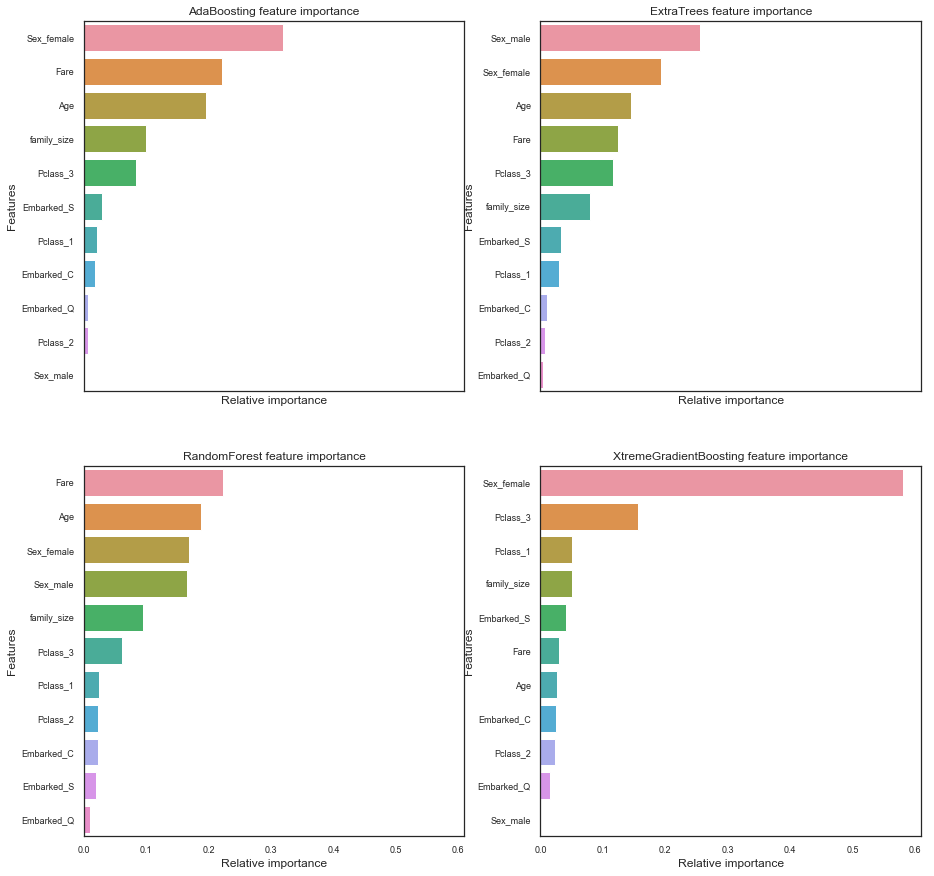

In [62]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", gsadaDTC.best_estimator_),("ExtraTrees",gsExtC.best_estimator_),
                     ("RandomForest",rf_grid.best_estimator_),("XtremeGradientBoosting",xgb_random.best_estimator_)
                    ,("XtremeGradientBoosting",gsGBC.best_estimator_)
                    ]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

Xtreme Gradient Boosting gave us the highest AUC. ANd the corresponding features (important to the model predictons) are Sex_female, Pclass_3, Pclass_1, Family SIze and Embarked_S.